## Aufgabe

Der Datensatz *a10.csv* enthält die monatlichen Absätze eines Medikamentes gegen Diabetes. Implementieren Sie ein geeignetes Modell zur Prädiktion der Absätze. Passen Sie zu diesem Zweck ggf. auch die Hilfsfunktionen zur Darstellung an.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import statsmodels.formula.api as smf
from statsmodels.tsa import tsatools
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics import tsaplots

def regressionSummary(y_true, y_predicted):
    y_true = np.asarray(y_true)
    y_predicted = np.asarray(y_predicted)
    y_residuals = y_true - y_predicted
    metrics = [
        ('Summe Abweichungen', sum(y_residuals)),
        ('Summe absolute Abweichungen', sum(abs(y_residuals))),
        ('Mittlerer Fehler', sum(y_residuals) / len(y_residuals)),
        ('Mittlerer absoluter Fehler', sum(abs(y_residuals)) / len(y_residuals)),
        ('Wurzel des durchschnittlichen Fehlerquadrats', np.sqrt(mean_squared_error(y_true, y_predicted)))
    ]
    if all(yt != 0 for yt in y_true):
        metrics.extend([
            ('Mittlerer prozentualer Fehler', 100 * sum(y_residuals / y_true) / len(y_residuals)),
            ('Mittlerer absoluter prozentualer Fehler', 100 * sum(abs(y_residuals / y_true) / len(y_residuals))),
        ])
    maxlength = max(len(m[0]) for m in metrics)
    fmt1 = f'{{:>{maxlength}}} : {{:.4f}}'    
    for metric, value in metrics:
        print(fmt1.format(metric, value))

def singleGraphLayout(ax, ylim, train_df, valid_df):
    ax.set_xlim('1991', '2008-6')
    ax.set_ylim(*ylim)
    ax.set_xlabel('Zeit')
    one_month = pd.Timedelta('31 days')
    
    xtrain = (min(train_df.index), max(train_df.index)-one_month)
    xvalid = (min(valid_df.index)+one_month, max(valid_df.index)-one_month)
    xtv = xtrain[1]+0.5*(xvalid[0]-xtrain[1])
    
    ypos = 0.9*ylim[1]+0.1*ylim[0]
    ax.add_line(plt.Line2D(xtrain, (ypos, ypos), color='black', linewidth=0.5))
    ax.add_line(plt.Line2D(xvalid, (ypos, ypos), color='black', linewidth=0.5))
    ax.axvline(x=xtv, ymin=0, ymax=1, color='black', linewidth=0.5)
    
    ypos = 0.925*ylim[1]+0.075*ylim[0]
    ax.text('1998', ypos, 'Training')
    ax.text('2006-1', ypos, 'Validation')
    
def graphLayout(axes, train_df, valid_df):
    singleGraphLayout(axes[0], [0, 40], train_df, valid_df)
    singleGraphLayout(axes[1], [-40, 40], train_df, valid_df)
    train_df.plot(y='sales', ax=axes[0], color='C0', linewidth=0.75)
    valid_df.plot(y='sales', ax=axes[0], color='C0', linestyle='dashed', linewidth=0.75)
    axes[1].axhline(y=0, xmin=0, xmax=1, color='black', linewidth=0.5)
    axes[0].set_xlabel('')
    axes[0].set_ylabel('Absatz in tausend')
    axes[1].set_ylabel('Vorhersagefehler')
    if axes[0].get_legend():
        axes[0].get_legend().remove()

a10_df = pd.read_csv('../Vorlesungsunterlagen/Daten/a10.csv')
a10_df
a10_df['Date'] = pd.to_datetime(a10_df.date, format='%Y-%m-%d')
a10_ts = pd.Series(a10_df.value.values, index=a10_df.Date, name='sales')
a10_ts

Date
1991-07-01     3.526591
1991-08-01     3.180891
1991-09-01     3.252221
1991-10-01     3.611003
1991-11-01     3.565869
                ...    
2008-02-01    21.654285
2008-03-01    18.264945
2008-04-01    23.107677
2008-05-01    22.912510
2008-06-01    19.431740
Name: sales, Length: 204, dtype: float64

# Trendmodell hinzufügen

In [2]:
a10_df = tsatools.add_trend(a10_ts, trend='t')
a10_df

,sales,trend
Date,,
1991-07-01,3.526591,1.0
1991-08-01,3.180891,2.0
1991-09-01,3.252221,3.0
1991-10-01,3.611003,4.0
1991-11-01,3.565869,5.0
...,...,...
2008-02-01,21.654285,200.0
2008-03-01,18.264945,201.0
2008-04-01,23.107677,202.0


# Regression

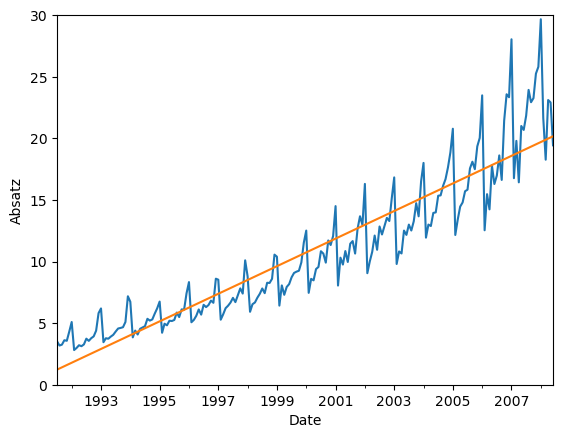

In [3]:
a10_lin_reg = smf.ols(formula='sales ~ trend', data=a10_df).fit()
ax = a10_ts.plot()
ax.set_xlabel('Zeit')
ax.set_ylabel('Absatz')
ax.set_ylim(0, 30)
a10_lin_reg.predict(a10_df).plot(ax=ax)
plt.show()

# Vorhersage

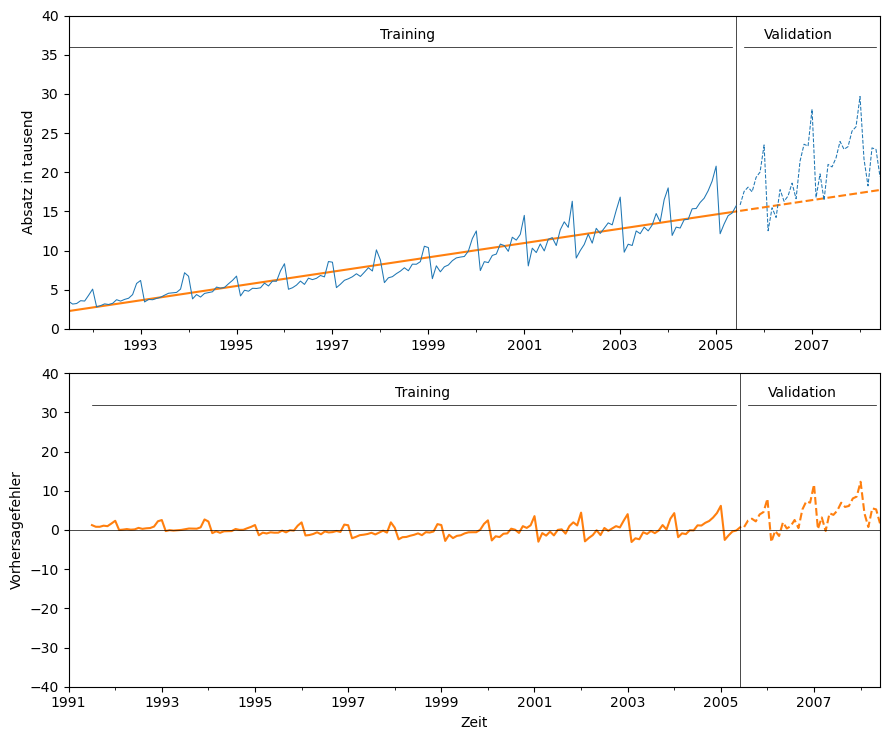

In [4]:
n_valid = 36 
n_train = len(a10_ts) - n_valid
train_df = a10_df[:n_train]
valid_df = a10_df[n_train:]

a10_prediction_linear = smf.ols(formula='sales ~ trend', data=train_df).fit()
predicted_linear = a10_prediction_linear.predict(valid_df)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 7.5))
a10_prediction_linear.predict(train_df).plot(ax=axes[0], color='C1')
a10_prediction_linear.predict(valid_df).plot(ax=axes[0], color='C1', linestyle='dashed')

residual = train_df.sales - a10_prediction_linear.predict(train_df)
residual.plot(ax=axes[1], color='C1')
residual = valid_df.sales - a10_prediction_linear.predict(valid_df)
residual.plot(ax=axes[1], color='C1', linestyle='dashed')
graphLayout(axes, train_df, valid_df)
plt.tight_layout()
plt.show()

# Auswertung der Kennzahlen

In [5]:
print(a10_prediction_linear.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     983.7
Date:                Wed, 28 May 2025   Prob (F-statistic):           1.16e-71
Time:                        09:51:13   Log-Likelihood:                -308.31
No. Observations:                 168   AIC:                             620.6
Df Residuals:                     166   BIC:                             626.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2128      0.236      9.360      0.0

# Saisonalität

In [6]:
a10_df = tsatools.add_trend(a10_ts, trend='c')
a10_df['Month'] = a10_df.index.month
a10_df

,sales,const,Month
Date,,,
1991-07-01,3.526591,1.0,7
1991-08-01,3.180891,1.0,8
1991-09-01,3.252221,1.0,9
1991-10-01,3.611003,1.0,10
1991-11-01,3.565869,1.0,11
...,...,...,...
2008-02-01,21.654285,1.0,2
2008-03-01,18.264945,1.0,3
2008-04-01,23.107677,1.0,4


In [7]:
train_df = a10_df[:n_train]
valid_df = a10_df[n_train:]
a10_prediction_season = smf.ols(formula='sales ~ C(Month)', data=train_df).fit()
predicted_season = a10_prediction_season.predict(valid_df)
print(a10_prediction_season.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     1.391
Date:                Wed, 28 May 2025   Prob (F-statistic):              0.182
Time:                        09:51:13   Log-Likelihood:                -463.01
No. Observations:                 168   AIC:                             950.0
Df Residuals:                     156   BIC:                             987.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         11.4090      1.056     10.

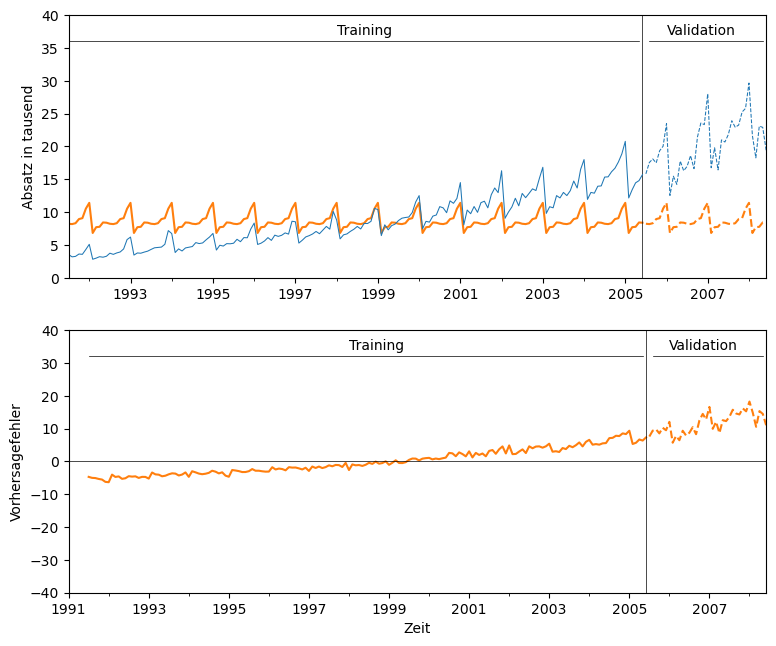

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 7.5))
a10_prediction_season.predict(train_df).plot(ax=axes[0], color='C1')
a10_prediction_season.predict(valid_df).plot(ax=axes[0], color='C1', linestyle='dashed')

residual = train_df.sales - a10_prediction_season.predict(train_df)
residual.plot(ax=axes[1], color='C1')
residual = valid_df.sales - a10_prediction_season.predict(valid_df)
residual.plot(ax=axes[1], color='C1', linestyle='dashed')
graphLayout(axes, train_df, valid_df)
plt.show()

In [9]:
a10_df = tsatools.add_trend(a10_ts, trend='ct')
a10_df['Month'] = a10_df.index.month
train_df = a10_df[:n_train]
valid_df = a10_df[n_train:]
a10_prediction_trend_season = smf.ols(formula='sales ~ trend + np.square(trend) * C(Month)', data=train_df).fit()
predicted_trend_season = a10_prediction_trend_season.predict(valid_df)
print(a10_prediction_trend_season.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     520.4
Date:                Wed, 28 May 2025   Prob (F-statistic):          9.43e-127
Time:                        09:51:13   Log-Likelihood:                -94.454
No. Observations:                 168   AIC:                             238.9
Df Residuals:                     143   BIC:                             317.0
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

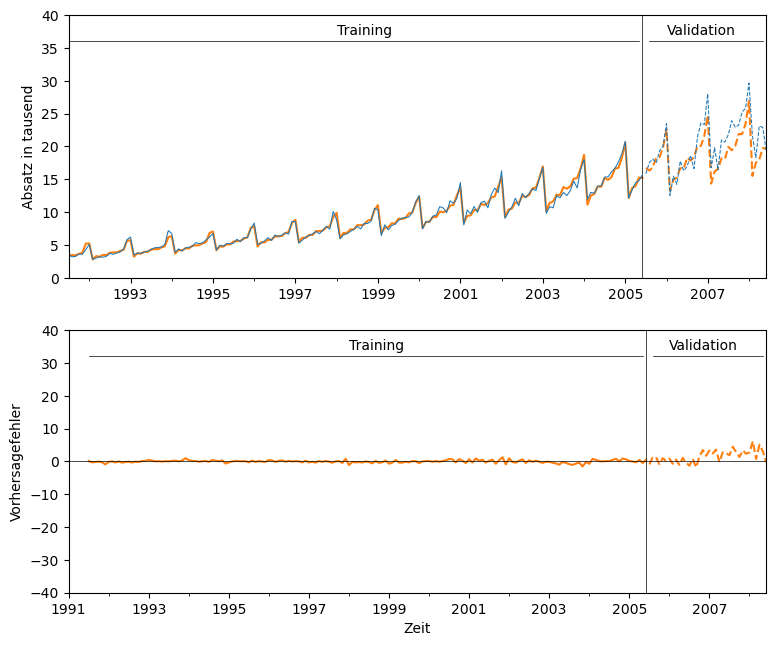

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 7.5))
a10_prediction_trend_season.predict(train_df).plot(ax=axes[0], color='C1')
a10_prediction_trend_season.predict(valid_df).plot(ax=axes[0], color='C1', linestyle='dashed')

residual_train = train_df.sales - a10_prediction_trend_season.predict(train_df)
residual_train.plot(ax=axes[1], color='C1')
residual_valid = valid_df.sales - a10_prediction_trend_season.predict(valid_df)
residual_valid.plot(ax=axes[1], color='C1', linestyle='dashed')
graphLayout(axes, train_df, valid_df)
plt.show()